# Climate Change Sentiment Predictor

This project aims to develop a program that, given a tweet relating to climate change, can predict whether the user's sentiment is sympathetic regarding climate change or not. Using data from a dataset of tweets with a manually labeled sentiment to train from, we aim to help future analysis regarding climate change through this program that looks into human sentiments through tweets. By providing a program that automatically labels sentiments, this project can easily provide future research with numerous and timely data to use.

This project is developed by:

- Alvarado, Enrique Luis
- Bassig, Lance Raphael
- Roxas, Dennis Christian
- Surara, Ron Christian

## 1. Importing the dataset and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import wordcloud

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('Climate_Sentiments_Twitter.csv')
df.head()

id              date  retweets                   source  \
0  2.184935e+09  12-22-2020 23:22      71.0          Twitter Web App   
1  5.086586e+08  12-10-2020 14:30      14.0  Twitter for Advertisers   
2  2.607105e+09  12-22-2020 21:28       0.0          Twitter Web App   
3  1.960966e+07  12-22-2020 21:24       0.0          Twitter Web App   
4  1.960966e+07  12-21-2020 22:52       1.0          Twitter Web App   

                         author  likes  \
0                      GO GREEN   91.0   
1               Elsevier Energy   98.0   
2                  Arwyn Thomas    1.0   
3  Tom Gillispie, EDITOR/WRITER    0.0   
4  Tom Gillispie, EDITOR/WRITER    1.0   

                                                text    twitter_name  \
0  The death of summer Arctic ice our Earth coole...    ECOWARRIORSS   
1  Elsevier and the EditorsinChief are pleased to...  ElsevierEnergy   
2  From better climate change education to improv...         siwarr5   
3  climate change Links to FIXING CLIMATE CHANGE ...    EDITORatWORK   
4  climate change The 11TH HOUR FOR THE EARTH cli...    EDITORatWORK   

                          location verified  followers  friends  polarity  \
0                              NaN    False    23415.0  20439.0 -0.054365   
1                  Oxford, England    False     6615.0    508.0  0.387500   
2                       Carmarthen    False       22.0    133.0  0.261905   
3  Rural Hall, North Carolina, USA    False     4191.0   3708.0  0.000000   
4  Rural Hall, North Carolina, USA    False     4191.0   3708.0  0.000000   

   subjectivity 1st review 2nd review 3rd review sympathy?  \
0      0.426984       news        pro        pro  positive   
1      0.633333       news       news       news  positive   
2      0.345238       news    neutral    neutral   neutral   
3      0.000000       news    neutral       news  positive   
4      0.000000       anti        pro        pro  positive   

  Hidden * change to 'hide' to hide verdict, helpful to avoid biases while reviewing  
0                                                NaN                                  
1      *remove the cell above when 3rd reviewer time                                  
2                                                NaN                                  
3                                                NaN                                  
4                                                NaN

## Function and Constant Declarations

In [2]:
C_TEST_POSITIVE = '#bde69c'
C_TEST_NEUTRAL = '#fce26a'
C_TEST_NEGATIVE = '#ff8080'

C_TEST_POSITIVE_H = 93
C_TEST_NEUTRAL_H = 49
C_TEST_NEGATIVE_H = 1

C_POSITIVE = '#80c6ff'
C_NEUTRAL = '#bba9e8'
C_NEGATIVE = '#ff8080'

C_POSITIVE_H = 207
C_NEUTRAL_H = 257
C_NEGATIVE_H = 1


# FUNCTION DECLARATIONS

# Horizontal Bar Plot Generator from Dictionary
def gen_barhplot(srcdict, vals_label="0",fig_title="", bar_color=""):
    
    srcdf_labels = list(srcdict.keys())
    srcdf_data = list(srcdict.values())
    srcdf = pd.DataFrame(data=srcdf_data, index=srcdf_labels, columns=[vals_label])

    srcdf.sort_values([vals_label], ascending=[True], inplace=True)

    ax = srcdf[-30:].plot(title=fig_title, figsize=(16, 8), kind="barh", color=("Blue" if bar_color == "" else bar_color))

# Wordcloud Generator from Dictionary
def gen_wordcloud(source_dict, common_highf_words=[], hue=-1,word_num_limit=200,gradient_step=3,fig_title=""):
    
        
    # generate wordcloud from frequency dictionary

    temp_freq_storage = {}

    # set frequency common highest-frequency words to 0
    for word in common_highf_words:
        try:
            temp_freq_storage[word] = source_dict[word]
            source_dict[word] = 0
        except KeyError:
            pass
        
    max_stat = max(list(source_dict.values()))
    # print(f"Most occurrences of word: %d" % max_stat)
    
    def custom_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
        # print(f"%s: %f" % (word, (100*source_dict[word])/max_stat))
        saturation_val = min((gradient_step * 100 * source_dict[word]) // max_stat, 100)
        lightness_val = min((gradient_step * 100 * source_dict[word]) // (2 * max_stat), 50)
        return "hsl(%d, %d%%, %d%%)" % (abs(hue), (0 if hue < 0 else 1) * saturation_val, lightness_val)
    

    # generate wordcloud
    gen_wordcloud_fig = wordcloud.WordCloud(width=1600, height=1600,
                            mode="RGBA",
                            background_color=None,
                            max_words=word_num_limit,
                            min_font_size=1).generate_from_frequencies(frequencies=source_dict)

    # restore word frequencies
    for word in common_highf_words:
        try:
            source_dict[word] = temp_freq_storage[word]
        except KeyError:
            pass

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.title(fig_title)
    plt.imshow(gen_wordcloud_fig.recolor(color_func=custom_color_func, random_state=0), interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\test\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Data Preprocessing

Since working with a column that has a '?' is troublesome, we will be transforming the 'sympathy?' column to simply 'sympathy'

In [4]:
#Transforming the sympathy? column to sympathy
df.rename(columns={"sympathy?":"sympathy"}, inplace=True)

### 2.1 Data Cleaning

In [5]:
#Dropping unneeded columns
df = df[['text', 'sympathy']]
# df = df.sample(frac=1).reset_index(drop=True)
df.head()

text  sympathy
0  The death of summer Arctic ice our Earth coole...  positive
1  Elsevier and the EditorsinChief are pleased to...  positive
2  From better climate change education to improv...   neutral
3  climate change Links to FIXING CLIMATE CHANGE ...  positive
4  climate change The 11TH HOUR FOR THE EARTH cli...  positive

In [6]:
#Check if there are rows with missing values
df.isna().value_counts()

text   sympathy
False  False       461
dtype: int64

### 2.2 Data Encoding

In [7]:
#Transforming the sympathy column to numerical values using the replacement method
params = {"negative": -1, "neutral": 0, "positive": 1}
df['sympathy'].replace(params, inplace=True)
df.head()

text  sympathy
0  The death of summer Arctic ice our Earth coole...         1
1  Elsevier and the EditorsinChief are pleased to...         1
2  From better climate change education to improv...         0
3  climate change Links to FIXING CLIMATE CHANGE ...         1
4  climate change The 11TH HOUR FOR THE EARTH cli...         1

### 2.3 Data Representation

In [8]:
#Creating the feature(s) and target vectors
features = df.drop("sympathy", axis=1)
target = df["sympathy"]

features.head()

text
0  The death of summer Arctic ice our Earth coole...
1  Elsevier and the EditorsinChief are pleased to...
2  From better climate change education to improv...
3  climate change Links to FIXING CLIMATE CHANGE ...
4  climate change The 11TH HOUR FOR THE EARTH cli...

### 2.4 Text Data Tokenization

In [9]:
#Tokenize the text data using RegexpTokenizer
textdata = features['text']
n = len(textdata)
tokenizer = RegexpTokenizer(r'\w+')
tokenizedtext = []

for i in range(n):
    #Convert text data to lowercase
    lower = textdata.iloc[i].lower()
    
    #Tokenize
    wordsarray = tokenizer.tokenize(lower)
    tokenizedtext.append(wordsarray)

#print(tokenizedText)

### 2.5 Text Data Cleaning

In [10]:
#Removing stop words using nlkt
englishstopwords = set(stopwords.words('english'))
englishstopwords.add("amp")
shortertext = []

for tweet in tokenizedtext:
    shortertweet = []
    for word in tweet:
        if word not in englishstopwords:
            word = word.strip()
            if (word.isdigit() == False and len(word) >= 2):
                shortertweet.append(word)
    shortertext.append(shortertweet)

#print(shorterText)

In [11]:
#Stemming using PorterStemmer
porterstemmer = PorterStemmer()
stemmedtext = []
for tweet in shortertext:
    stemmedwords = []
    for word in tweet:
        stemmedwords.append(porterstemmer.stem(word))
    convertback = ' '.join(stemmedwords)
    stemmedtext.append(convertback)

#Create a separate dataframe dfcv for later EDA
dfcv = df.copy()
dfcv['text'] = stemmedtext

dfcv.head()

text  sympathy
0  death summer arctic ice earth cooler year away...         1
1  elsevi editorsinchief pleas share first volum ...         1
2  better climat chang educ improv sustain here g...         0
3  climat chang link fix climat chang climatechan...         1
4  climat chang 11th hour earth climatechang glob...         1

### 2.5 Text Data Vectorization

In [12]:
#Vectorizing the text data using TFIDvectorizer for Modelling
tfid = TfidfVectorizer()
vectorizedtfid = tfid.fit_transform(stemmedtext)

#print(vectorizedtfid)
#print(tfid.vocabulary_)

## 3. Exploratory Data Analysis

### 3.0 Preparation of Data for Exploration

In [13]:
senti_dict = [{}, {}, {}]

for i in range(dfcv.shape[0]):
    wordarray = dfcv['text'].iloc[i].split(" ")
    sentiment = dfcv['sympathy'].iloc[i]
    for word in wordarray:
        try:
            senti_dict[sentiment][word] += 1
        except KeyError:
            senti_dict[sentiment][word] = 1

for i in range(3):
    senti_dict[i] = dict(sorted(senti_dict[i].items(), key=lambda item: item[1], reverse=True))

prodict = senti_dict[1]
neutraldict = senti_dict[0]
antidict = senti_dict[-1]

### 3.1 Distribution of Sentiments

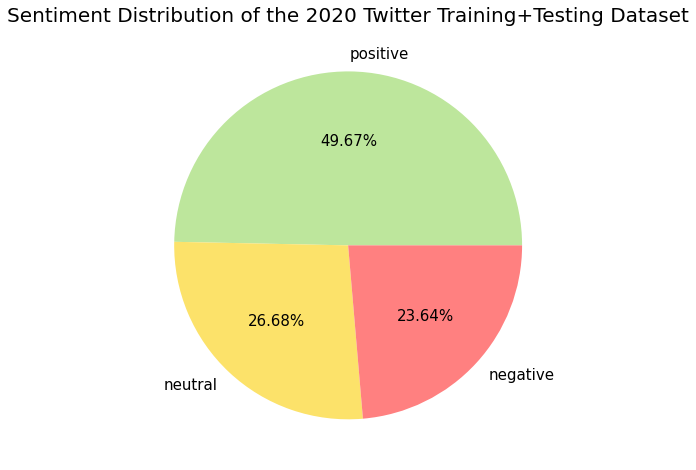

In [14]:
plt.figure(figsize = (8, 8))
values = df['sympathy'].value_counts().values
labels = ['positive', 'neutral', 'negative']
plt.pie(values, labels=labels, textprops={'fontsize': 15}, autopct="%.2f%%", colors=[C_TEST_POSITIVE,C_TEST_NEUTRAL,C_TEST_NEGATIVE])
plt.title('Sentiment Distribution of the 2020 Twitter Training+Testing Dataset', fontsize=20)
plt.show()

### 3.2 Top 30 Occurrences of Words in Sympathetic Climate Change (positive) Tweets

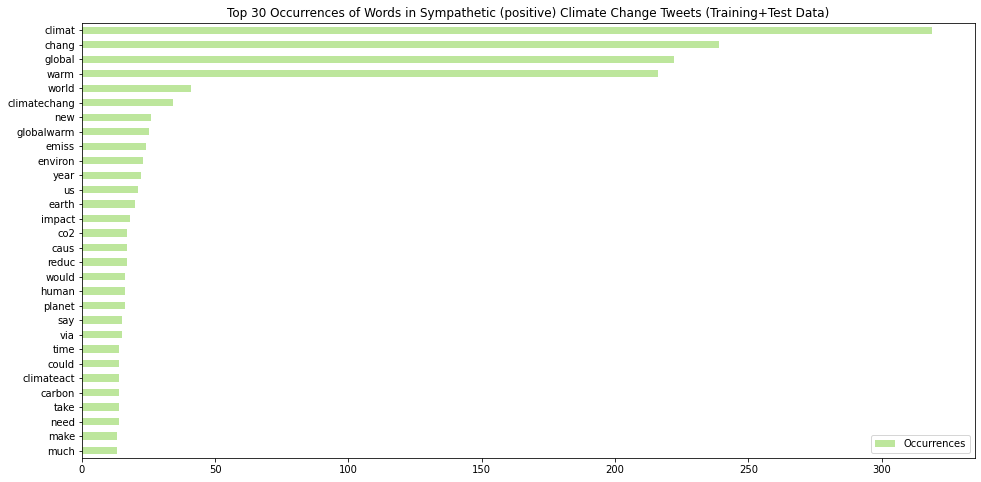

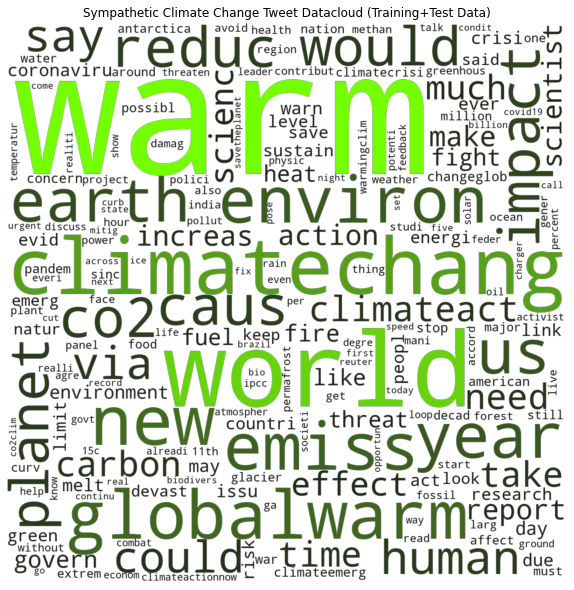

In [15]:
#plt.figure(figsize=(20,8))
#plt.title("Top 30 Occurrences of Words in Sympathetic Climate Change (positive) Tweets")
#keys = list(prodict.keys())[:30]
#vals = list(prodict.values())[:30]
#sns.barplot(x=vals, y=keys)

#print(valuecounts)

gen_barhplot(prodict, "Occurrences", "Top 30 Occurrences of Words in Sympathetic (positive) Climate Change Tweets (Training+Test Data)", C_TEST_POSITIVE)
gen_wordcloud(prodict, ["climat", "chang", "global"], hue=C_TEST_POSITIVE_H, fig_title="Sympathetic Climate Change Tweet Datacloud (Training+Test Data)", gradient_step=4.65)

### 3.4 Top 30 Occurrences of Words in Neutral Climate Change (neutral) Tweets

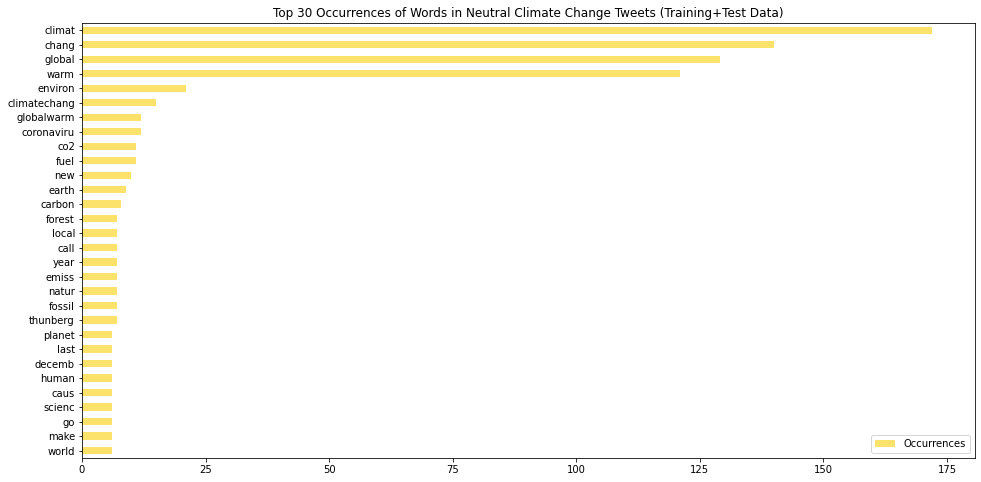

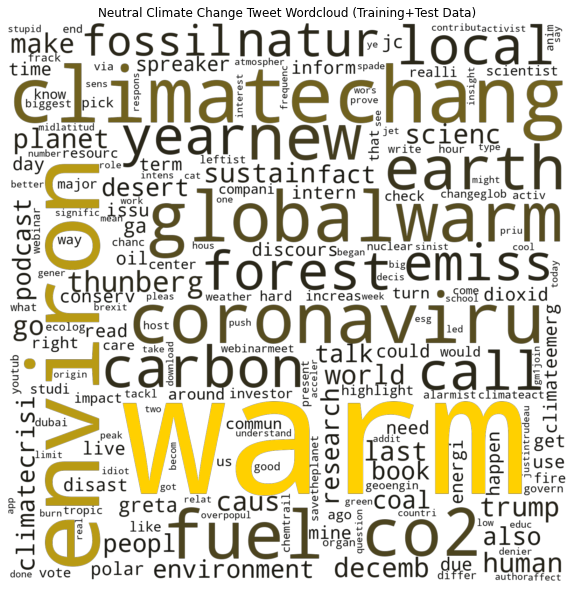

In [16]:
gen_barhplot(neutraldict, "Occurrences", "Top 30 Occurrences of Words in Neutral Climate Change Tweets (Training+Test Data)", C_TEST_NEUTRAL)
gen_wordcloud(neutraldict, ["climat", "chang", "global"], C_TEST_NEUTRAL_H, gradient_step=4.65, fig_title="Neutral Climate Change Tweet Wordcloud (Training+Test Data)")

### 3.3 Top 30 Occurrences of Words in Aphathetic Climate Change (anti) Tweets

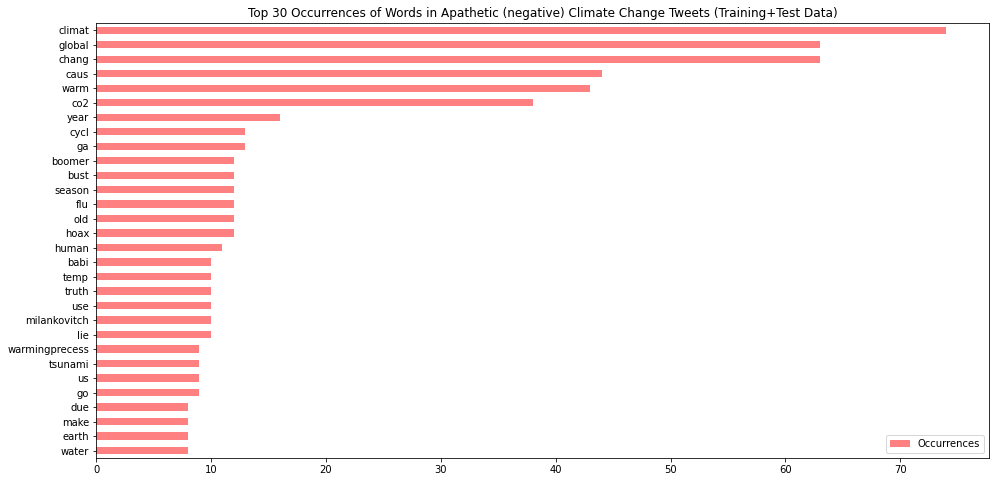

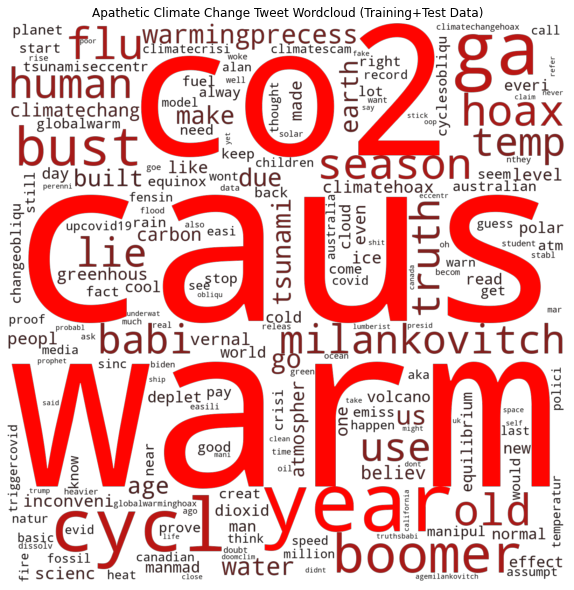

In [17]:
gen_barhplot(antidict, "Occurrences", "Top 30 Occurrences of Words in Apathetic (negative) Climate Change Tweets (Training+Test Data)", C_TEST_NEGATIVE)
gen_wordcloud(antidict, ["climat", "chang", "global"], C_TEST_NEGATIVE_H, gradient_step=2.75, fig_title="Apathetic Climate Change Tweet Wordcloud (Training+Test Data)")

## 4. Data Modelling

### 4.1 Using Logistic Regression

In [18]:
#
# Use "vectorizedtfid" for the features matrix
# and "target" dataframe for the target vector
#

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectorizedtfid, target, test_size=0.30, shuffle=True, random_state=0)

from sklearn.linear_model import LogisticRegression
alpha_complement = 0
for s in ['newton-cg','lbfgs','liblinear']:
    print ("Solver: ", s)
    logisticRegr = LogisticRegression(C=1000000,solver=s,max_iter=1000000)
    logisticRegr.fit(x_train,y_train)
    score = logisticRegr.score(x_test,y_test)
    if s == 'lbfgs':
        alpha_complement = score
    print("Accuracy Score:", score)

Solver:  newton-cg
Accuracy Score: 0.6618705035971223
Solver:  lbfgs
Accuracy Score: 0.6690647482014388
Solver:  liblinear
Accuracy Score: 0.6402877697841727


### 4.2 Using Support Vector Machine

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectorizedtfid, target, test_size=0.30, random_state=0)

from sklearn import svm

#Linear
print("Linear Kernel:")
SVMclassifier = svm.SVC(kernel='linear',C=1000000, max_iter=-1)
SVMclassifier.fit(x_train,y_train)
score = SVMclassifier.score(x_test,y_test)
print("Accuracy Score:", score)

print()

#Polynomial
print("Polynomial Kernel:")
for d in [0.0,1.0,3.0,7.0,9.0]:
    #C matches, low C low acc and high C high acc, at least for poly
    for r in [100]:
        SVMclassifier = svm.SVC(kernel='poly',degree=d,coef0=r, C=1000000,max_iter=-1)
        SVMclassifier.fit(x_train,y_train)
        score = SVMclassifier.score(x_test,y_test)
        print("Accuracy Score:", score, "Degree: " ,d, "Coef: ", r)

#RBF
print()
print("RBF Kernel:")
for c in [1.0,10.0,100.0,10000000.0]:
    for g in [0.1,1.0,100.0,10000000.0,'scale','auto']:
        SVMclassifier = svm.SVC(kernel='rbf',C=c,gamma=g,max_iter=-1)
        SVMclassifier.fit(x_train,y_train)
        score = SVMclassifier.score(x_test,y_test)
        print("Accuracy Score:", score, "C: ", c, "Gamma: ", g)
    
#Sigmoid
print()
print("Sigmoid:")
for c in [1,2,3,7,9,100]:
    SVMclassifier = svm.SVC(kernel='sigmoid',coef0=c,max_iter=-1)
    SVMclassifier.fit(x_train,y_train)
    score = SVMclassifier.score(x_test,y_test)
    print("Accuracy Score:", score, "Coef: ", c)

Linear Kernel:
Accuracy Score: 0.6762589928057554

Polynomial Kernel:
Accuracy Score: 0.5035971223021583 Degree:  0.0 Coef:  100
Accuracy Score: 0.6762589928057554 Degree:  1.0 Coef:  100
Accuracy Score: 0.6762589928057554 Degree:  3.0 Coef:  100
Accuracy Score: 0.6762589928057554 Degree:  7.0 Coef:  100
Accuracy Score: 0.6762589928057554 Degree:  9.0 Coef:  100

RBF Kernel:
Accuracy Score: 0.5035971223021583 C:  1.0 Gamma:  0.1
Accuracy Score: 0.5827338129496403 C:  1.0 Gamma:  1.0
Accuracy Score: 0.5179856115107914 C:  1.0 Gamma:  100.0
Accuracy Score: 0.5179856115107914 C:  1.0 Gamma:  10000000.0
Accuracy Score: 0.5827338129496403 C:  1.0 Gamma:  scale
Accuracy Score: 0.5035971223021583 C:  1.0 Gamma:  auto
Accuracy Score: 0.6762589928057554 C:  10.0 Gamma:  0.1
Accuracy Score: 0.6330935251798561 C:  10.0 Gamma:  1.0
Accuracy Score: 0.5179856115107914 C:  10.0 Gamma:  100.0
Accuracy Score: 0.5179856115107914 C:  10.0 Gamma:  10000000.0
Accuracy Score: 0.6330935251798561 C:  10.0 Gam

### 4.3 Naive-Bayes

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(vectorizedtfid, target, test_size=0.30, random_state=0)

from sklearn.naive_bayes import MultinomialNB

NBclassifier = MultinomialNB()
NBclassifier.fit(x_train,y_train)
score = NBclassifier.score(x_test,y_test)

print("Accuracy Score:", score)

Accuracy Score: 0.5827338129496403


## 5. Data Testing

From above, we can see that the highest accuracy achieved is that of the Limited-memory Broyden–Fletcher–Goldfarb–Shanno (lbfgs) solver of Logistic Regresstion at 73.38%, hence we will be using this in predicting the sentiments of 1000 tweets from 2021-2022 and another 1000 tweets from 2016-2017.

### 5.1 Predicting Sentiments of tweets from 2021 - 2022

In [21]:
logisticRegr = LogisticRegression(C=1000000,solver='lbfgs',max_iter=1000000)
logisticRegr.fit(x_train,y_train)
score = logisticRegr.score(x_test,y_test)
testing = pd.read_csv('testing_data.csv')

#Tokenize the text data using RegexpTokenizer
textdata = testing['text']
n = len(textdata)
tokenizedtext = []

for i in range(n):
    #Convert text data to lowercase
    lower = textdata.iloc[i].lower()
    
    #Tokenize
    wordsarray = tokenizer.tokenize(lower)
    tokenizedtext.append(wordsarray)

#Removing stop words using nlkt
englishstopwords = set(stopwords.words('english'))
englishstopwords.add("amp")
shortertext = []

for tweet in tokenizedtext:
    shortertweet = []
    for word in tweet:
        if word not in englishstopwords:
            word = word.strip()
            if (word.isdigit() == False and len(word) >= 2):
                shortertweet.append(word)
    shortertext.append(shortertweet)

#Stemming using PorterStemmer
stemmedtext = []
for tweet in shortertext:
    stemmedwords = []
    for word in tweet:
        stemmedwords.append(porterstemmer.stem(word))
    convertback = ' '.join(stemmedwords)
    stemmedtext.append(convertback)

    
#Vectorizing the text data using TFIDvectorizer for Modelling
vectorizedtesting = tfid.transform(stemmedtext)
test_predict = logisticRegr.predict(vectorizedtesting)

### 5.1.1 Exploring 2021-2022 tweets

**Prepare Data for Exploration**

In [22]:
# Create dataframe for exploration
xplore = pd.DataFrame()

# Prepare dataframe for exploration
xplore['text'] = stemmedtext
xplore['sympathy'] = test_predict # Insert prediction column

senti_dict = [{}, {}, {}]

for i in range(xplore.shape[0]):
    wordarray = xplore['text'].iloc[i].split(" ")
    sentiment = xplore['sympathy'].iloc[i]
    for word in wordarray:
        try:
            senti_dict[sentiment][word] += 1
        except KeyError:
            senti_dict[sentiment][word] = 1

for i in range(3):
    senti_dict[i] = dict(sorted(senti_dict[i].items(), key=lambda item: item[1], reverse=True))

prodict = senti_dict[1]
neutraldict = senti_dict[0]
antidict = senti_dict[-1]

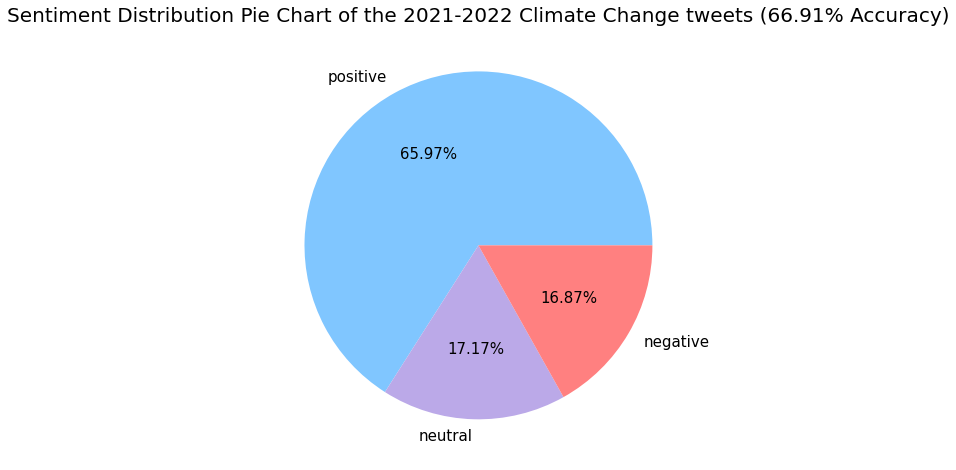

In [23]:
plt.figure(figsize = (8, 8))
values = pd.DataFrame(test_predict).value_counts().values
values_2022 = list(values)
labels = ['positive', 'neutral', 'negative']
plt.pie(values, labels=labels, textprops={'fontsize': 15}, autopct="%.2f%%", colors=[C_POSITIVE, C_NEUTRAL, C_NEGATIVE])
plt.title(f'Sentiment Distribution Pie Chart of the 2021-2022 Climate Change tweets (%.2f%% Accuracy)' % (alpha_complement*100), fontsize=20)
plt.show()

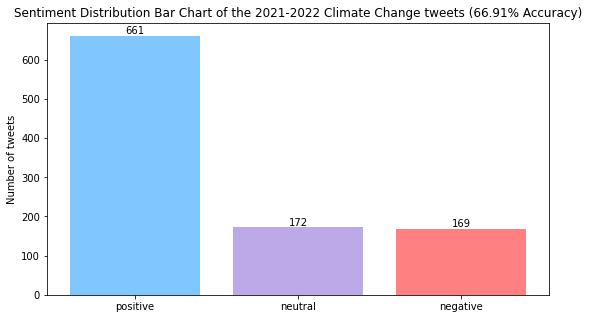

In [24]:
labels = ['positive', 'neutral', 'negative']
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar([-1, 0, 1], values, color=(C_POSITIVE, C_NEUTRAL, C_NEGATIVE))
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(labels)
ax.set_ylabel('Number of tweets')
ax.set_title("Sentiment Distribution Bar Chart of the 2021-2022 Climate Change tweets (%.2f%% Accuracy)" % (alpha_complement * 100))
ax.bar_label(bars)
plt.show()

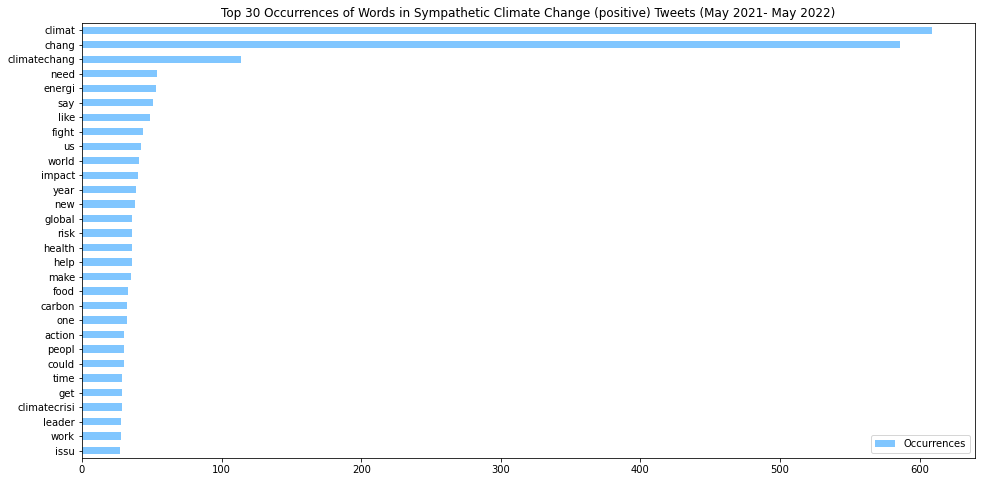

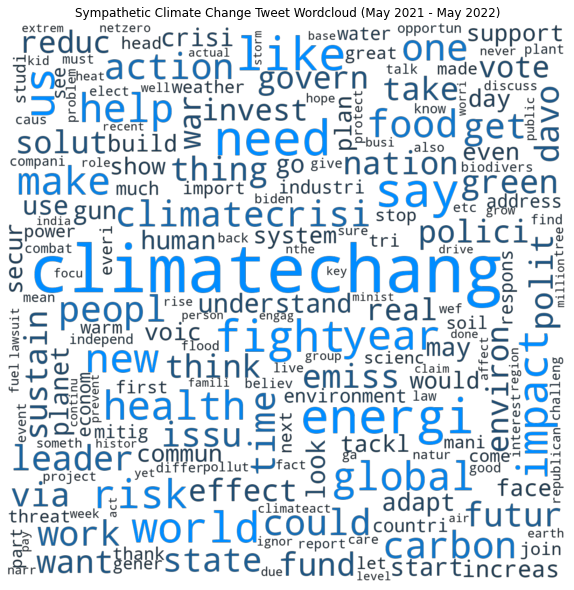

In [25]:
# Exploration of positive tweets

gen_barhplot(prodict,"Occurrences", "Top 30 Occurrences of Words in Sympathetic Climate Change (positive) Tweets (May 2021- May 2022)", C_POSITIVE)
gen_wordcloud(prodict, ["climat", "chang"], hue=C_POSITIVE_H, fig_title="Sympathetic Climate Change Tweet Wordcloud (May 2021 - May 2022)")

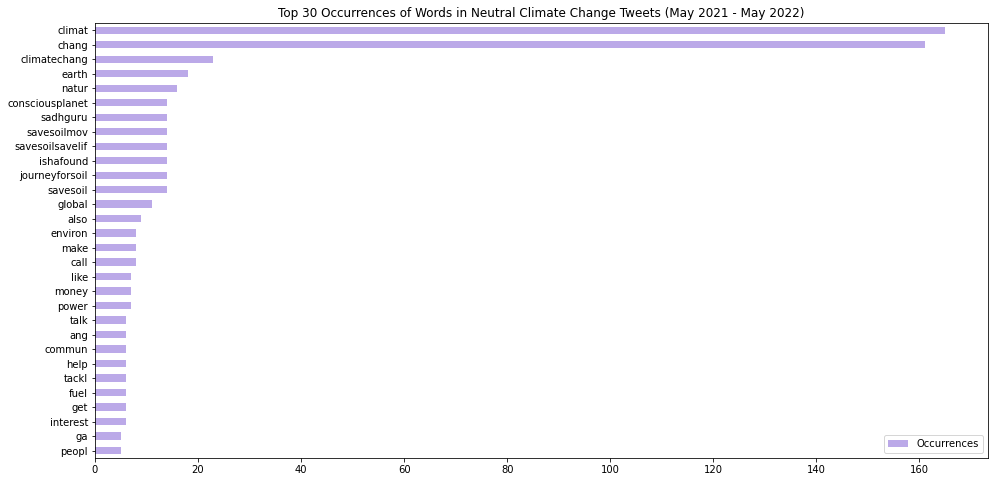

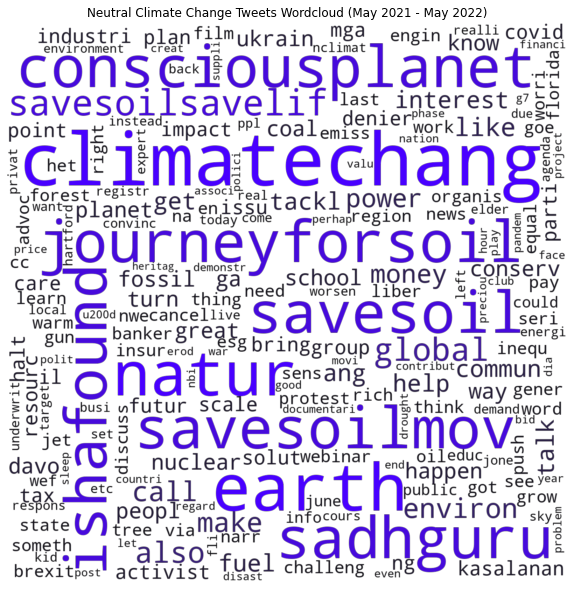

In [26]:
# Exploration of Neutral Tweets

gen_barhplot(neutraldict,"Occurrences", "Top 30 Occurrences of Words in Neutral Climate Change Tweets (May 2021 - May 2022)", C_NEUTRAL)
gen_wordcloud(neutraldict, ["climat", "chang"], hue=C_NEUTRAL_H, gradient_step=1.5, fig_title="Neutral Climate Change Tweets Wordcloud (May 2021 - May 2022)")

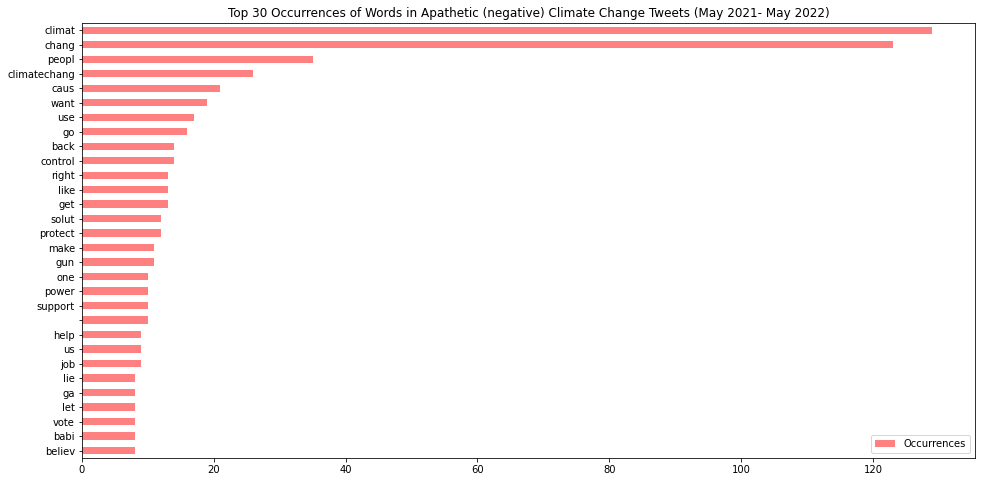

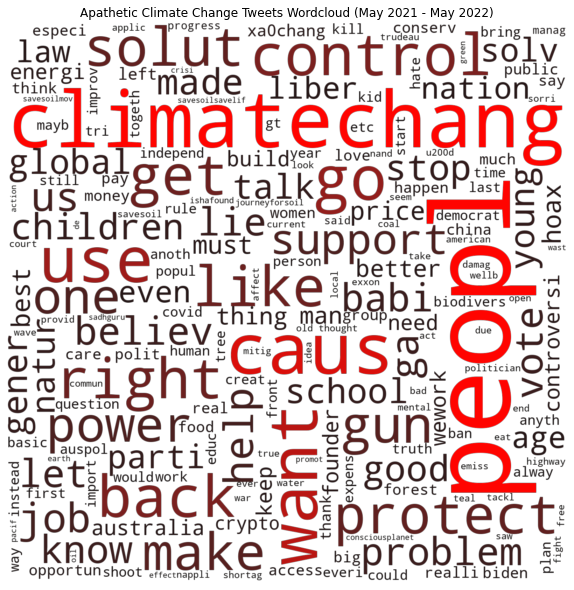

In [27]:
# Exploration of Negative Tweets

gen_barhplot(antidict,"Occurrences", "Top 30 Occurrences of Words in Apathetic (negative) Climate Change Tweets (May 2021- May 2022)", C_NEGATIVE)
gen_wordcloud(antidict, ["climat", "chang"], C_NEGATIVE_H, gradient_step=1.5, fig_title="Apathetic Climate Change Tweets Wordcloud (May 2021 - May 2022)")

### 5.2 Predicting Sentiments of tweets from 5 years ago (2016-2017)

In [28]:
logisticRegr = LogisticRegression(C=1000000,solver='lbfgs',max_iter=1000000)
logisticRegr.fit(x_train,y_train)
score = logisticRegr.score(x_test,y_test)
testing = pd.read_csv('5yearsago.csv')
#Tokenize the text data using RegexpTokenizer
textdata = testing['text']
n = len(textdata)
tokenizedtext = []

for i in range(n):
    #Convert text data to lowercase
    lower = textdata.iloc[i].lower()
    
    #Tokenize
    wordsarray = tokenizer.tokenize(lower)
    tokenizedtext.append(wordsarray)
    
#Removing stop words using nlkt
englishstopwords = set(stopwords.words('english'))
englishstopwords.add("amp")
shortertext = []

for tweet in tokenizedtext:
    shortertweet = []
    for word in tweet:
        if word not in englishstopwords:
            word = word.strip()
            if (word.isdigit() == False and len(word) >= 2):
                shortertweet.append(word)
    shortertext.append(shortertweet)
    
#Stemming using PorterStemmer
stemmedtext = []
for tweet in shortertext:
    stemmedwords = []
    for word in tweet:
        stemmedwords.append(porterstemmer.stem(word))
    convertback = ' '.join(stemmedwords)
    stemmedtext.append(convertback)
#Vectorizing the text data using TFIDvectorizer for Modelling
vectorizedtesting = tfid.transform(stemmedtext)

test_predict = logisticRegr.predict(vectorizedtesting)

### 5.2.1 Exploratory Data Analysis of 2016-2017 Dataset

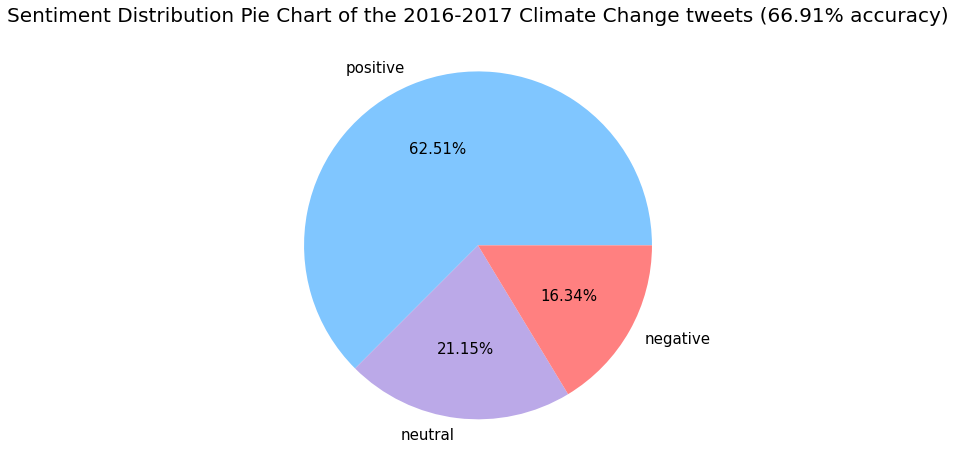

In [29]:
# Exploration of Data Composition

plt.figure(figsize = (8, 8))
values = pd.DataFrame(test_predict).value_counts().values
values_2016 = list(values)
labels = ['positive', 'neutral', 'negative']
plt.pie(values, labels=labels, textprops={'fontsize': 15}, autopct="%.2f%%",colors=[C_POSITIVE, C_NEUTRAL, C_NEGATIVE])
plt.title(f'Sentiment Distribution Pie Chart of the 2016-2017 Climate Change tweets (%.2f%% accuracy)' % (alpha_complement * 100), fontsize=20)
plt.show()

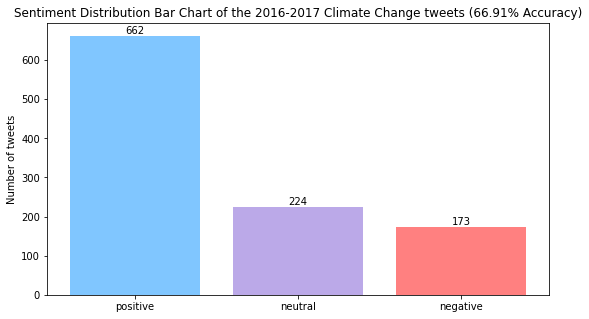

In [30]:
# Exploration of Data Count

labels = ['positive', 'neutral', 'negative']
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar([-1, 0, 1], values, color=[C_POSITIVE, C_NEUTRAL, C_NEGATIVE])
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(labels)
ax.set_ylabel('Number of tweets')
ax.set_title("Sentiment Distribution Bar Chart of the 2016-2017 Climate Change tweets (%.2f%% Accuracy)" % (alpha_complement * 100))
ax.bar_label(bars)

plt.show()

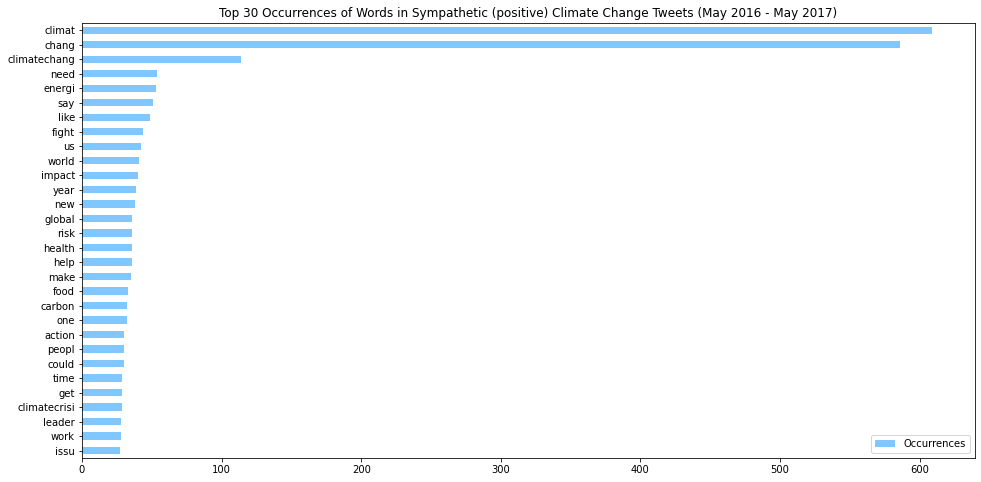

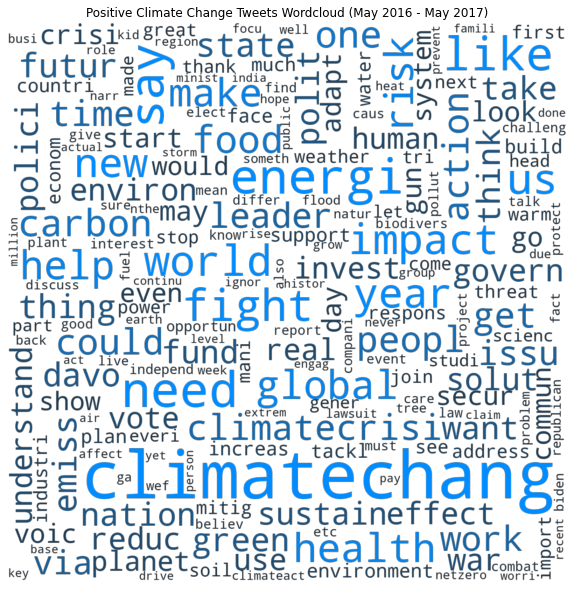

In [31]:
# Exploration of Positive Tweets

gen_barhplot(prodict,"Occurrences", "Top 30 Occurrences of Words in Sympathetic (positive) Climate Change Tweets (May 2016 - May 2017)", C_POSITIVE)
gen_wordcloud(prodict, ["climat", "chang"], C_POSITIVE_H, fig_title="Positive Climate Change Tweets Wordcloud (May 2016 - May 2017)")

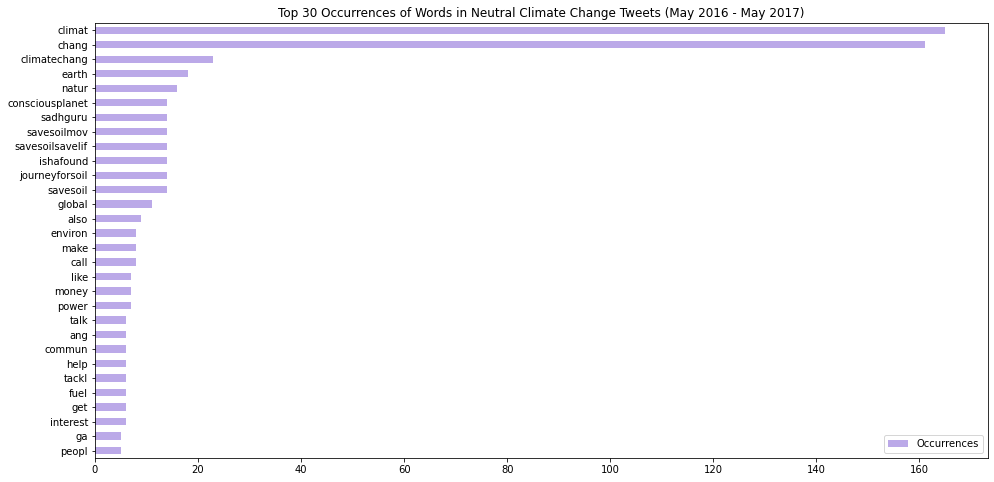

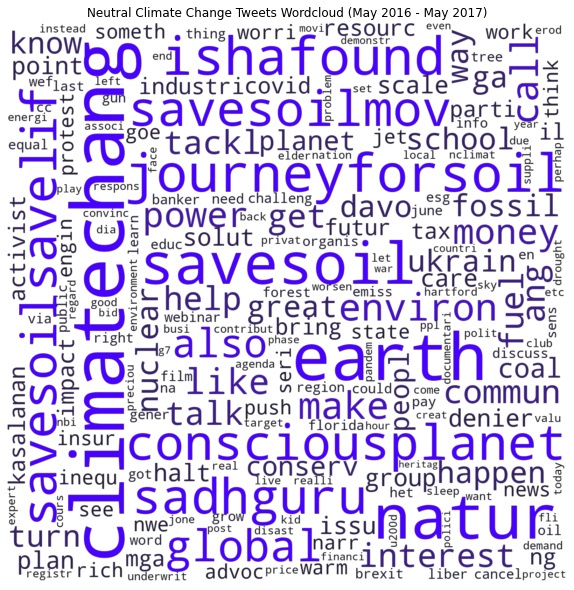

In [32]:
# Exploration of Neutral Tweets

gen_barhplot(neutraldict,"Occurrences", "Top 30 Occurrences of Words in Neutral Climate Change Tweets (May 2016 - May 2017)", C_NEUTRAL)
gen_wordcloud(neutraldict, ["climat", "chang"], C_NEUTRAL_H, gradient_step=2.5, fig_title="Neutral Climate Change Tweets Wordcloud (May 2016 - May 2017)")

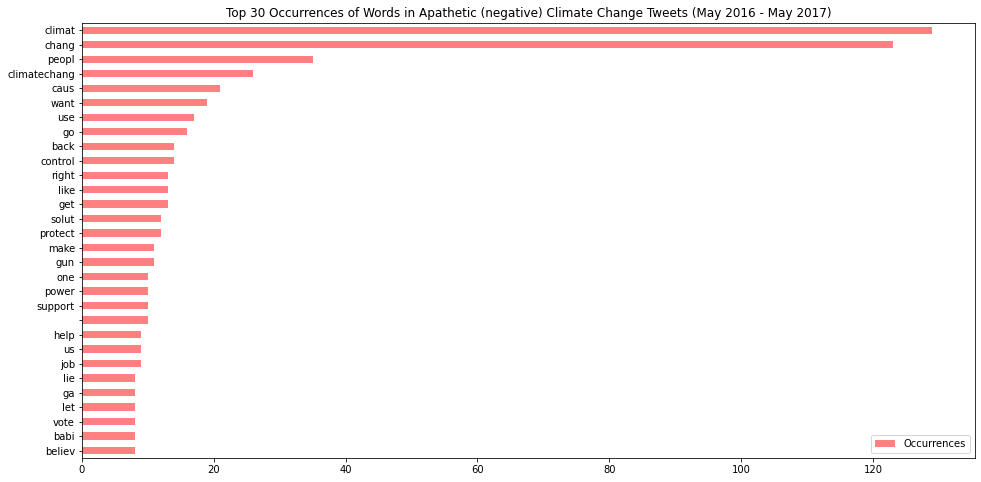

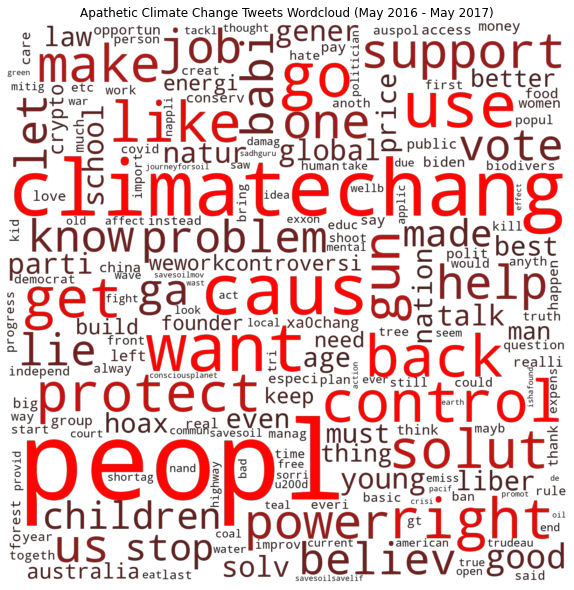

In [33]:
# Exploration of Positive Tweets

gen_barhplot(antidict,"Occurrences", "Top 30 Occurrences of Words in Apathetic (negative) Climate Change Tweets (May 2016 - May 2017)", C_NEGATIVE)
gen_wordcloud(antidict, ["climat", "chang"], C_NEGATIVE_H,gradient_step=2.5, fig_title="Apathetic Climate Change Tweets Wordcloud (May 2016 - May 2017)")

In [34]:
expected = [((i / sum(values_2016)) *  sum(values_2022)) for i in values_2016]  # 2016-2017 %
observed = values_2022  # 2021-2022 count
alpha = 1 - alpha_complement

print("Expected: ", end="")
print(expected)
print("Observed: ", end="")
print(observed)
print(f"LBFGS Accuracy: %f" % (alpha_complement))

from scipy import stats
chi_squared, p_value = stats.chisquare(f_obs= observed,   # Array of observed counts
                f_exp= expected)   # Array of expected counts

print()
print("Null Hypothesis: No significant change in sentiment towards climate change")
print("Alternative Hypothesis: E significant change in sentiment towards climate change")
print(f"Alpha: %f" % (alpha))
print(f"Reject null hypothesis? (P-value < alpha?): {p_value < alpha}")

Expected: [626.3682719546742, 211.94334277620396, 163.68838526912182]
Observed: [661, 172, 169]
LBFGS Accuracy: 0.669065

Null Hypothesis: No significant change in sentiment towards climate change
Alternative Hypothesis: E significant change in sentiment towards climate change
Alpha: 0.330935
Reject null hypothesis? (P-value < alpha?): True
